<h1 align="center">Lab 4. Advanced methods in NLP</h1>

<hr>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Word2Vec

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a high-dimensional space (typically of several hundred dimensions), with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

### Preparing the Input 

Python library <a href="http://radimrehurek.com/gensim/tutorial.html" target="_blank">gensim</a> <a href="http://radimrehurek.com/gensim/models/word2vec.html" target="_blank">word2vect</a> can compute vector representations of
words using a few different techniques. Gensim's implementation of word2vec is
incredibly intuitive and easy to use. Starting from the
beginning, gensim’s word2vec expects a sequence of sentences as its input. But
first we need to import modules for future lookup through the folders, importing
files and logging library to follow the process of training model.
>If you don’t have genism library installed you just have to follow this
<a href="https://radimrehurek.com/gensim/install.html">instructions</a>.


Look at an example gensim

In [3]:
# import modules
import gensim,os,re

Starting from the beginning, gensim’s Word2Vec expects a sequence of sentences as its input. Each sentence a list of words (utf8 strings):

In [4]:
sentences = [['first', 'sentence'], ['second', 'sentence']]
# train Word2Vec on the two sentences
model = gensim.models.Word2Vec(sentences, min_count=1)

Keeping the input as a Python built-in list is convenient, but can use up a lot of RAM when the input is large.

Gensim only requires that the input must provide sentences sequentially, when iterated over. No need to keep everything in RAM: we can provide one sentence, process it, forget it, load another sentence. For example, if our input is strewn across several files on disk, with one sentence per line, then instead of loading everything into an in-memory list, we can process the input file by file, line by line.

As the data will use the creations of Shakespeare: Romeo and Juliet and Hamlet

In [7]:
class GeneratorSentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split()
sentences = GeneratorSentences('./ws') # a memory-friendly iterator
model = gensim.models.Word2Vec(sentences)
print (sentences.__iter__().__next__())

['Act', 'I']


Say we want to further preprocess the words from the files — convert to unicode, lowercase, remove numbers, extract named entities… All of this can be done inside the GeneratorSentences iterator and word2vec doesn’t need to know. All that is required is that the input yields one sentence (list of utf8 words) after another.

In [8]:
from stop_words import get_stop_words


class GeneratorSentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
        self.en_stop = get_stop_words('en')
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                line=re.sub(u'[^\w\s]', "", line.replace('*','').replace('\'',''))
                for i in range(10):
                    line.replace(str(i),'')
                yield [i for i in line.lower().split() if len(i) > 2 and not i in self.en_stop]


In [11]:
sentences = GeneratorSentences('./ws') # a memory-friendly iterator
model = gensim.models.Word2Vec(sentences)
print (sentences.__iter__().__next__())

['act']


Note to advanced users: calling Word2Vec(sentences) will run two passes over the sentences iterator. The first pass collects words and their frequencies to build an internal dictionary tree structure.

The second pass trains the neural model.

These two passes can also be initiated manually, in case your input stream is non-repeatable (you can only afford one pass), and you’re able to initialize the vocabulary some other way:

In [14]:
model = gensim.models.Word2Vec() # an empty model, no training
model.build_vocab(sentences)  # can be a non-repeatable, 1-pass generator
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)  # can be a non-repeatable, 1-pass generator

(88033, 148995)

### Training 

Word2vec accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

In [15]:
%time model = gensim.models.Word2Vec(sentences)  # default value is 5

CPU times: user 1.15 s, sys: 3.03 ms, total: 1.16 s
Wall time: 1.1 s


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

In [16]:
%time model = gensim.models.Word2Vec(sentences, min_count=10)  # default value is 5

CPU times: user 1.02 s, sys: 15.5 ms, total: 1.04 s
Wall time: 992 ms


Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

In [17]:
%time model = gensim.models.Word2Vec(sentences, size=300)  # default value is 100

CPU times: user 1.2 s, sys: 7.49 ms, total: 1.2 s
Wall time: 1.11 s


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list here) is for training parallelization, to speed up training:

In [18]:
%time model = gensim.models.Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.09 s


The workers parameter has only effect if you have Cython installed. Without Cython, you’ll only be able to use one core because of the GIL (and word2vec training will be miserably slow).

#### Memory 

At its core, word2vec model parameters are stored as matrices (NumPy arrays). Each array is #vocabulary (controlled by min_count parameter) times #size (size parameter) of floats (single precision aka 4 bytes).

Three such matrices are held in RAM (work is underway to reduce that number to two, or even one). So if your input contains 100,000 unique words, and you asked for layer size=200, the model will require approx. 100,000*200*4*3 bytes = ~229MB.

There’s a little extra memory needed for storing the vocabulary tree (100,000 words would take a few megabytes), but unless your words are extremely loooong strings, memory footprint will be dominated by the three matrices above.

#### Storing and loading models
You can store/load models using the standard gensim methods which uses pickle
internally, optionally map‘ing the model’s internal large NumPy matrices into
virtual memory directly from disk files, for inter-process memory sharing.
 

In [19]:
model.save('./tmp/model.bin')
new_model = gensim.models.Word2Vec.load('./tmp/model.bin') 

#### Using the model
Word2vec supports several word similarity tasks out of the box. Explore the similarity of the two words:
 

In [21]:
print (model.wv.similarity('woman', 'man'))

0.7874455


Also we can display the desired number of very similar words to the tasks word

In [23]:
sim = model.wv.most_similar('king', topn=19)
sim

[('thou', 0.9954736232757568),
 ('thee', 0.9952509999275208),
 ('thy', 0.9950230121612549),
 ('will', 0.9949464797973633),
 ('ham', 0.994921863079071),
 ('tis', 0.9945659041404724),
 ('good', 0.9942381381988525),
 ('come', 0.994158923625946),
 ('shall', 0.9938963651657104),
 ('lord', 0.9936346411705017),
 ('like', 0.9935482740402222),
 ('ill', 0.9934672713279724),
 ('gone', 0.9934252500534058),
 ('one', 0.993378221988678),
 ('may', 0.9933605194091797),
 ('doth', 0.99325031042099),
 ('now', 0.993196964263916),
 ('let', 0.9931305646896362),
 ('say', 0.9931144714355469)]

Build a dendrogram of similarity of these words

In [24]:
from scipy.cluster.hierarchy import ward, dendrogram

In [27]:
labels = ['king']+[i[0] for i in sim] # save labels for dendrogram, we also add king to list

#calculate similaryty matrix
sim_matrix = []
for i in range(len(labels)):
    t = []
    for j in range(len(labels)):
        t.append(model.wv.similarity(labels[i], labels[j]))
    sim_matrix.append(t[:])
    
linkage_matrix = ward(sim_matrix) #define the linkage_matrix using ward clustering pre-computed distances

Show dendrogram

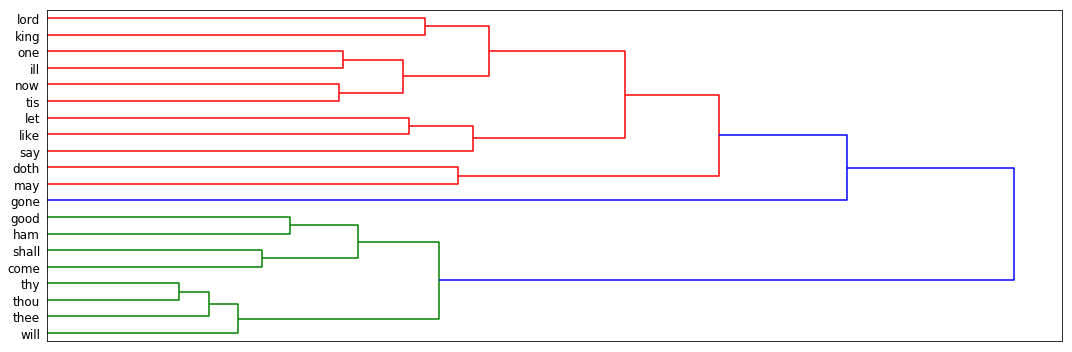

In [29]:
fig, ax = plt.subplots(figsize=(15, 5)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=labels, leaf_font_size=12.);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='false',      # ticks along the bottom edge are off
    top='false',         # ticks along the top edge are off
    labelbottom='false')

plt.tight_layout() #show plot with tight layout
plt.show()

The graph shows that the closest word see and Ile. Also, we see separation of similarity to small groups.

Also we can search for more subtle, indicating which words should be like and what does not

In [31]:
sim = model.wv.most_similar(positive=['man', 'king'], negative=['woman','death'], topn=20)
sim

[('gentlewoman', 0.4262744188308716),
 ('heeres', 0.42042994499206543),
 ('murther', 0.40542569756507874),
 ('selues', 0.3941044211387634),
 ('dutie', 0.3927497863769531),
 ('dye', 0.38644731044769287),
 ('lose', 0.38405466079711914),
 ('farre', 0.38091301918029785),
 ('winde', 0.3783870041370392),
 ('patience', 0.37233269214630127),
 ('asleep', 0.37090039253234863),
 ('fortune', 0.369281530380249),
 ('beleeue', 0.3639359474182129),
 ('mark', 0.3639031648635864),
 ('dream', 0.36183834075927734),
 ('gaue', 0.3603140115737915),
 ('purpose', 0.3597654700279236),
 ('mar', 0.3562401831150055),
 ('vse', 0.3546498715877533),
 ('beauty', 0.35389018058776855)]

Visualize results as we did above

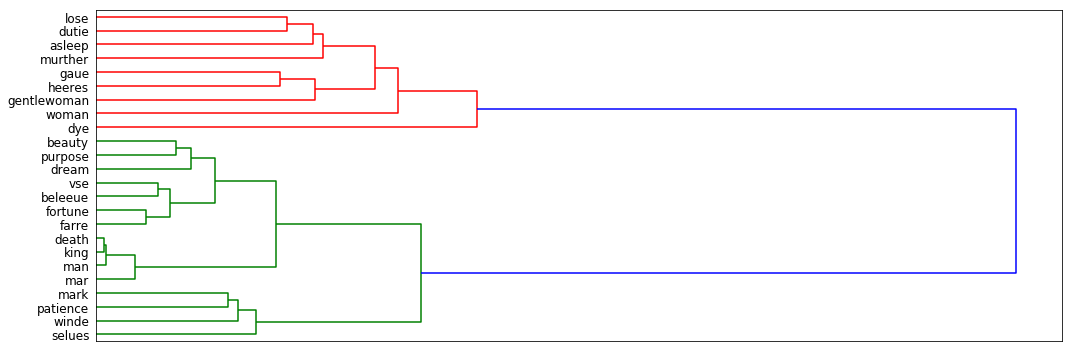

In [32]:
labels = ['man', 'king','woman','death']+[i[0] for i in sim]

sim_matrix = []
for i in range(len(labels)):
    t = []
    for j in range(len(labels)):
        t.append(model.wv.similarity(labels[i], labels[j]))
    sim_matrix.append(t[:])
    
linkage_matrix = ward(sim_matrix) 

fig, ax = plt.subplots(figsize=(15, 5)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=labels, leaf_font_size=12.);

plt.tick_params(\
    axis= 'x',          
    which='both',     
    bottom='off',     
    top='off',         
    labelbottom='off')

plt.tight_layout() 
plt.show()

Here we see apparent division into two groups, and one word did not get into any.

#### Evaluating 

Word2vec training is an unsupervised task, there’s no good way to objectively evaluate the result. Evaluation depends on your end application.

Google have released their testing set of about 20,000 syntactic and semantic test examples, following the “A is to B as C is to D” task.

Gensim support the same evaluation set, in exactly the same format:

In [34]:
model.wv.evaluate_word_analogies('questions-words.txt')

(0.0,
 [{'section': 'capital-common-countries', 'correct': [], 'incorrect': []},
  {'section': 'capital-world', 'correct': [], 'incorrect': []},
  {'section': 'currency', 'correct': [], 'incorrect': []},
  {'section': 'city-in-state', 'correct': [], 'incorrect': []},
  {'section': 'family',
   'correct': [],
   'incorrect': [('BOY', 'GIRL', 'BROTHER', 'SISTER'),
    ('BOY', 'GIRL', 'FATHER', 'MOTHER'),
    ('BOY', 'GIRL', 'HUSBAND', 'WIFE'),
    ('BOY', 'GIRL', 'KING', 'QUEEN'),
    ('BOY', 'GIRL', 'MAN', 'WOMAN'),
    ('BOY', 'GIRL', 'SON', 'DAUGHTER'),
    ('BROTHER', 'SISTER', 'FATHER', 'MOTHER'),
    ('BROTHER', 'SISTER', 'HUSBAND', 'WIFE'),
    ('BROTHER', 'SISTER', 'KING', 'QUEEN'),
    ('BROTHER', 'SISTER', 'MAN', 'WOMAN'),
    ('BROTHER', 'SISTER', 'SON', 'DAUGHTER'),
    ('BROTHER', 'SISTER', 'BOY', 'GIRL'),
    ('FATHER', 'MOTHER', 'HUSBAND', 'WIFE'),
    ('FATHER', 'MOTHER', 'KING', 'QUEEN'),
    ('FATHER', 'MOTHER', 'MAN', 'WOMAN'),
    ('FATHER', 'MOTHER', 'SON', 'DAUGHTER

## Exercise 1
>Build a Word2Vec model based on the H. G. Wells's book  "Time Machine" and save the 5 most similar words  with the `time` word into list `result`.<br>
><i>Note: it is necessary to remove the stop words and punctuation from the text. For the removal of stop words, use the library stop_words.</i>

In [44]:
from stop_words import get_stop_words
stop_words = get_stop_words('english')
# bible_kjv_words_without_s_w = [w for w in bible_kjv_words if w not in(stop_words)]
print(os.listdir(os.getcwd()))
book_path = './exercise'

sentences = GeneratorSentences(book_path) # a memory-friendly iterator
# model = gensim.models.Word2Vec(sentences)
print (sentences.__iter__().__next__())
model = gensim.models.Word2Vec() # an empty model, no training
model.build_vocab(sentences)  # can be a non-repeatable, 1-pass generator
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)  # can be a non-repeatable, 1-pass generator
model.save('./tmp/model.bin')
model = gensim.models.Word2Vec.load('./tmp/model.bin')

result = model.wv.most_similar('time', topn=5)
print(result)

['Lection_6_-_Advanced_NLP.pptx', 'tmp', 'func', 'doc2vec', 'BONUS_-_TensorFlow_FastText.ipynb', 'Lab_4._Advanced_methods_in_NLP.ipynb', 'exercise', 'ws', '.ipynb_checkpoints', 'questions-words.txt', 'tweets']
['time', 'machine']
[('little', 0.9969175457954407), ('one', 0.9968519806861877), ('seemed', 0.9965972900390625), ('came', 0.9964046478271484), ('saw', 0.9963849782943726)]


In [ ]:
Test.assertEqualsHashed(sorted(result), 'd92a85a12aeca490e199d4a002a30a06ba8a1c13', 'Incorrect data','Exercise 1 is successful')

## 2. Doc2Vec - Sentiment Analysis

The main purpose of Doc2Vec is associating arbitrary documents with labels, so labels are required. Doc2vec is an extension of word2vec that learns to correlate labels and words, rather than words with other words. Deeplearning4j’s implentation is intended to serve the Java, Scala and Clojure communities.<br>

The first step is coming up with a vector that represents the “meaning” of a document, which can then be used as input to a supervised machine learning algorithm to associate documents with labels.

In [53]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

# numpy
import numpy

# random
from random import shuffle

# classifier
from sklearn.linear_model import LogisticRegression

### Input Format


#### Feeding Data to Doc2Vec

Word2Vec simply converts a word into a vector.

Doc2Vec not only does that, but also aggregates all the words in a sentence into a vector. To do that, it simply treats a sentence label as a special word, and does some voodoo on that special word. Hence, that special word is a label for a sentence.

So we have to format sentences into
<pre>[['word1', 'word2', 'word3', 'lastword'], ['label1']]</pre>

LabeledSentence is simply a tidier way to do that. It contains a list of words, and a label for the sentence. We don’t really need to care about how LabeledSentence works exactly, we just have to know that it stores those two things – a list of words and a label.

However, we need a way to convert our new line separated corpus into a collection of LabeledSentences. The default constructor for the default LabeledLineSentence class in Doc2Vec can do that for a single text file, but can’t do that for multiple files. In classification tasks however, we usually deal with multiple documents (test, training, positive, negative etc). Ain’t that annoying?

So we write our own LabeledLineSentence class. The constructor takes in a dictionary that defines the files to read and the label prefixes sentences from that document should take on. Then, Doc2Vec can either read the collection directly via the iterator, or we can access the array directly. We also need a function to return a permutated version of the array of LabeledSentences. We’ll see why later on.

In [54]:
from stop_words import get_stop_words

en_stop = get_stop_words('en')

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    line = utils.to_unicode(line).lower().split()
                    line = [ re.sub(u'[^\w\s]', "",i) for i in line if i.find('/')<0 and i.find('\\')<0 and i.find('\'t')<0 and i.find('_')<0 and i.find('-')<0 and i.find('haha')<0]
                    line = [i for i in line if i.isalpha() and len(set(i))>2 and len(set(i))>0.5*len(i)]
                    line = [i for i in line if len(i)>3 and not(i in en_stop)]
                    yield TaggedDocument(line, [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    line = utils.to_unicode(line).lower().split()
                    line = [ re.sub(u'[^\w\s]', "",i) for i in line if i.find('/')<0 and i.find('\\')<0 and i.find('\'t')<0 and i.find('_')<0 and i.find('-')<0 and i.find('haha')<0]
                    line = [i for i in line if i.isalpha() and len(set(i))>2 and len(set(i))>0.5*len(i)]
                    line = [i for i in line if len(i)>3 and not(i in en_stop)]
                    self.sentences.append(TaggedDocument(line, [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffle(self.sentences)
        return self.sentences

Now we can feed the data files to LabeledLineSentence. As we mentioned earlier, LabeledLineSentence simply takes a dictionary with keys as the file names and values the special prefixes for sentences from that document. The prefixes need to be unique, so that there is no ambiguitiy for sentences from different documents.

The prefixes will have a counter appended to them to label individual sentences in the documetns.

In [74]:
sources = {'./doc2vec/test-neg.txt':'TEST_NEG', './doc2vec/test-pos.txt':'TEST_POS', './doc2vec/train-neg.txt':'TRAIN_NEG', './doc2vec/train-pos.txt':'TRAIN_POS', './doc2vec/train-unsup.txt':'TRAIN_UNS'}

sentences = LabeledLineSentence(sources)

### Model
#### Building the Vocabulary Table

Doc2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them). So we feed it the array of sentences. model.build_vocab takes an array of LabeledLineSentence, hence our to_array function in the LabeledLineSentences class.

If you’re curious about the parameters, do read the Word2Vec documentation. Otherwise, here’s a quick rundown:

- `min_count`: ignore all words with total frequency lower than this. You have to set this to 1, since the sentence labels only appear once. Setting it any higher than 1 will miss out on the sentences.
- `window`: the maximum distance between the current and predicted word within a sentence. Word2Vec uses a skip-gram model, and this is simply the window size of the skip-gram model.
- `size`: dimensionality of the feature vectors in output. 100 is a good number. If you’re extreme, you can go up to around 400.
- `sample`: threshold for configuring which higher-frequency words are randomly downsampled
- `workers`: use this many worker threads to train the model

In [75]:
model = Doc2Vec(min_count=1, window=15, vector_size=100, sample=1e-4, negative=5, workers=2)

model.build_vocab(sentences.to_array())

### Training Doc2Vec

Now we train the model. The model is better trained if in each training epoch, the sequence of sentences fed to the model is randomized. This is important: missing out on this steps gives you really shitty results. This is the reason for the sentences_perm method in our LabeledLineSentences class.

We train it for 10 epochs. 

In [76]:
for epoch in range(100):
    model.train(sentences.sentences_perm(), total_examples=model.corpus_count, epochs=model.epochs)

### Saving and Loading Models
To avoid training the model again, we can save it.

In [64]:
model.save('./tmp/imdb.d2v')

And load it.

In [65]:
model = Doc2Vec.load('./tmp/imdb.d2v')

### Inspecting the Model

Let’s see what our model gives. It seems that it has kind of understood the word good, since the most similar words to good are glamorous, spectacular, astounding etc. This is really awesome (and important), since we are doing sentiment analysis. 

In [77]:
model.wv.most_similar('good')

[('onecommercial', 0.894399106502533),
 ('interwebs', 0.8650221228599548),
 ('bedtime', 0.8252684473991394),
 ('babe', 0.7562777400016785),
 ('roasted', 0.740164041519165),
 ('forth', 0.7330279350280762),
 ('classic', 0.7079275846481323),
 ('hungry', 0.7008352279663086),
 ('premise', 0.6776745319366455),
 ('wake', 0.6771596670150757)]

We can also prop the hood open and see what the model actually contains. This is each of the vectors of the words and sentences in the model. We can access all of them using model.syn0 (for the geekier ones among you, syn0 is simply the output layer of the shallow neural network). 

In [78]:
model.docvecs['TRAIN_NEG_0']

array([-0.03005067, -0.6819912 , -0.3349187 ,  0.07391346,  0.22341055,
        0.04628614,  0.23256767,  0.05873444, -0.55894095, -0.23486517,
       -0.36680588,  0.11917661, -0.13702509,  0.18932612,  0.7206304 ,
        0.42937914,  0.4716985 , -0.06025427,  0.68106174, -0.47801837,
        0.8272207 ,  0.13182552, -0.23881125, -0.16193412,  0.08471882,
       -0.295945  ,  0.12895566, -0.47215778,  0.12778924, -1.0872355 ,
       -1.2225844 , -0.82264465,  0.0278074 , -0.53559375, -0.10552398,
        0.2498276 ,  0.5296455 , -0.03331922,  0.05871326, -0.18528758,
        0.28579783, -0.04736882, -0.15130346, -0.30138397,  0.29761374,
       -0.82050246, -0.82542074,  0.48532382,  1.0866742 , -0.27589044,
        0.52161175, -0.25215498,  0.2579136 ,  0.6815881 ,  0.75787944,
       -0.23685619, -0.41525432, -0.17967944, -0.04915382, -0.07368178,
       -0.07790107, -0.42341238,  0.41486844, -0.6022104 , -0.4320942 ,
        0.39441177,  0.15131824, -0.7807765 ,  0.34128565, -0.60

The numbers easier to analyze if there is a graphical representation of them. Just so we can visualize the word is not in us the constructed model, as each word is represented by an n-dimensional vector, and n is significantly greater than 2. With this challenge will help to cope TSNE. This istrement specifically designed to reduce the dimension of the data.

In [79]:
from sklearn.manifold import TSNE

 t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. More read there <a href="http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">TSNE</a>

The dimension of the input data

In [80]:
num_features = 100

Word vector for each vocabulary

In [87]:
vectors_origin = model.wv.syn0
print(vectors_origin)

[[-0.10553848 -1.0842258  -0.76795274 ... -0.4199952   0.7417019
   0.26966012]
 [-0.28579977 -1.1718401  -1.3470571  ... -0.9560237   0.89045244
  -0.5610897 ]
 [-1.129919   -1.8505228  -1.0482235  ... -0.8869746   0.7470007
   0.76396257]
 ...
 [-0.2843004  -0.15482526 -0.2725371  ...  0.28125617 -0.14870626
   0.6185682 ]
 [-0.2651475  -0.15161371 -0.28950283 ...  0.2545117  -0.13723058
   0.5754931 ]
 [ 0.13713278 -0.92546743 -0.01879775 ... -0.0956049   0.3137832
   0.06760986]]


/home/dmitriy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


The list of the model's vocabulary

In [90]:
vocab_list_origin = list(model.wv.vocab.keys()) 
print(vocab_list_origin)

['took', 'siri', 'made', 'exclusive', 'iphone', 'guys', 'happening', 'suddenly', 'fade', 'black', 'begin', 'vibrate', 'continuously', 'reboot', 'nonstop', 'dropped', 'callsmute', 'button', 'randomly', 'activatingperson', 'cant', 'hear', 'pull', 'phone', 'mobile', 'screen', 'dear', 'thank', 'beautiful', 'features', 'miss', 'ones', 'making', 'calls', 'texts', 'mulling', 'just', 'aint', 'shore', 'bout', 'nuther', 'social', 'media', 'profile', 'play', 'nice', 'hdmi', 'ipad', 'pretty', 'lame', 'give', 'apps', 'back', 'chris', 'poole', 'wrong', 'athens', 'review', 'docs', 'shows', 'work', 'needs', 'done', 'waited', 'line', 'nothing', 'fucking', 'genius', 'called', 'john', 'jean', 'stop', 'name', 'french', 'congratulations', 'suing', 'insurance', 'company', 'managed', 'make', 'shit', 'list', 'connect', 'network', 'less', 'useful', 'voicecontrol', 'worst', 'customer', 'service', 'experience', 'ever', 'arrogant', 'inept', 'combo', 'biltmore', 'apple', 'store', 'warning', 'spontaneously', 'loose

Extract non-stopwords from vocab_list and vectors

In [91]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
vocab_list = []
vecs = []

for i in range(0, len(vocab_list_origin)):
    vocab = vocab_list_origin[i]

    if vocab not in stops and len(vocab) > 3:
        vocab_list.append(vocab)
        vecs.append(model[vocab].reshape((1, num_features)))

vecs = np.concatenate(vecs)

vectors = np.array(vecs, dtype='float') #TSNE expects float type values

Build TSNE model and transform our input data

In [92]:
n_components = 2    # 2 for 2D
model_tsne = TSNE(n_components, random_state=0)
words_tsne = model_tsne.fit_transform(vectors)

Now we can plot the data

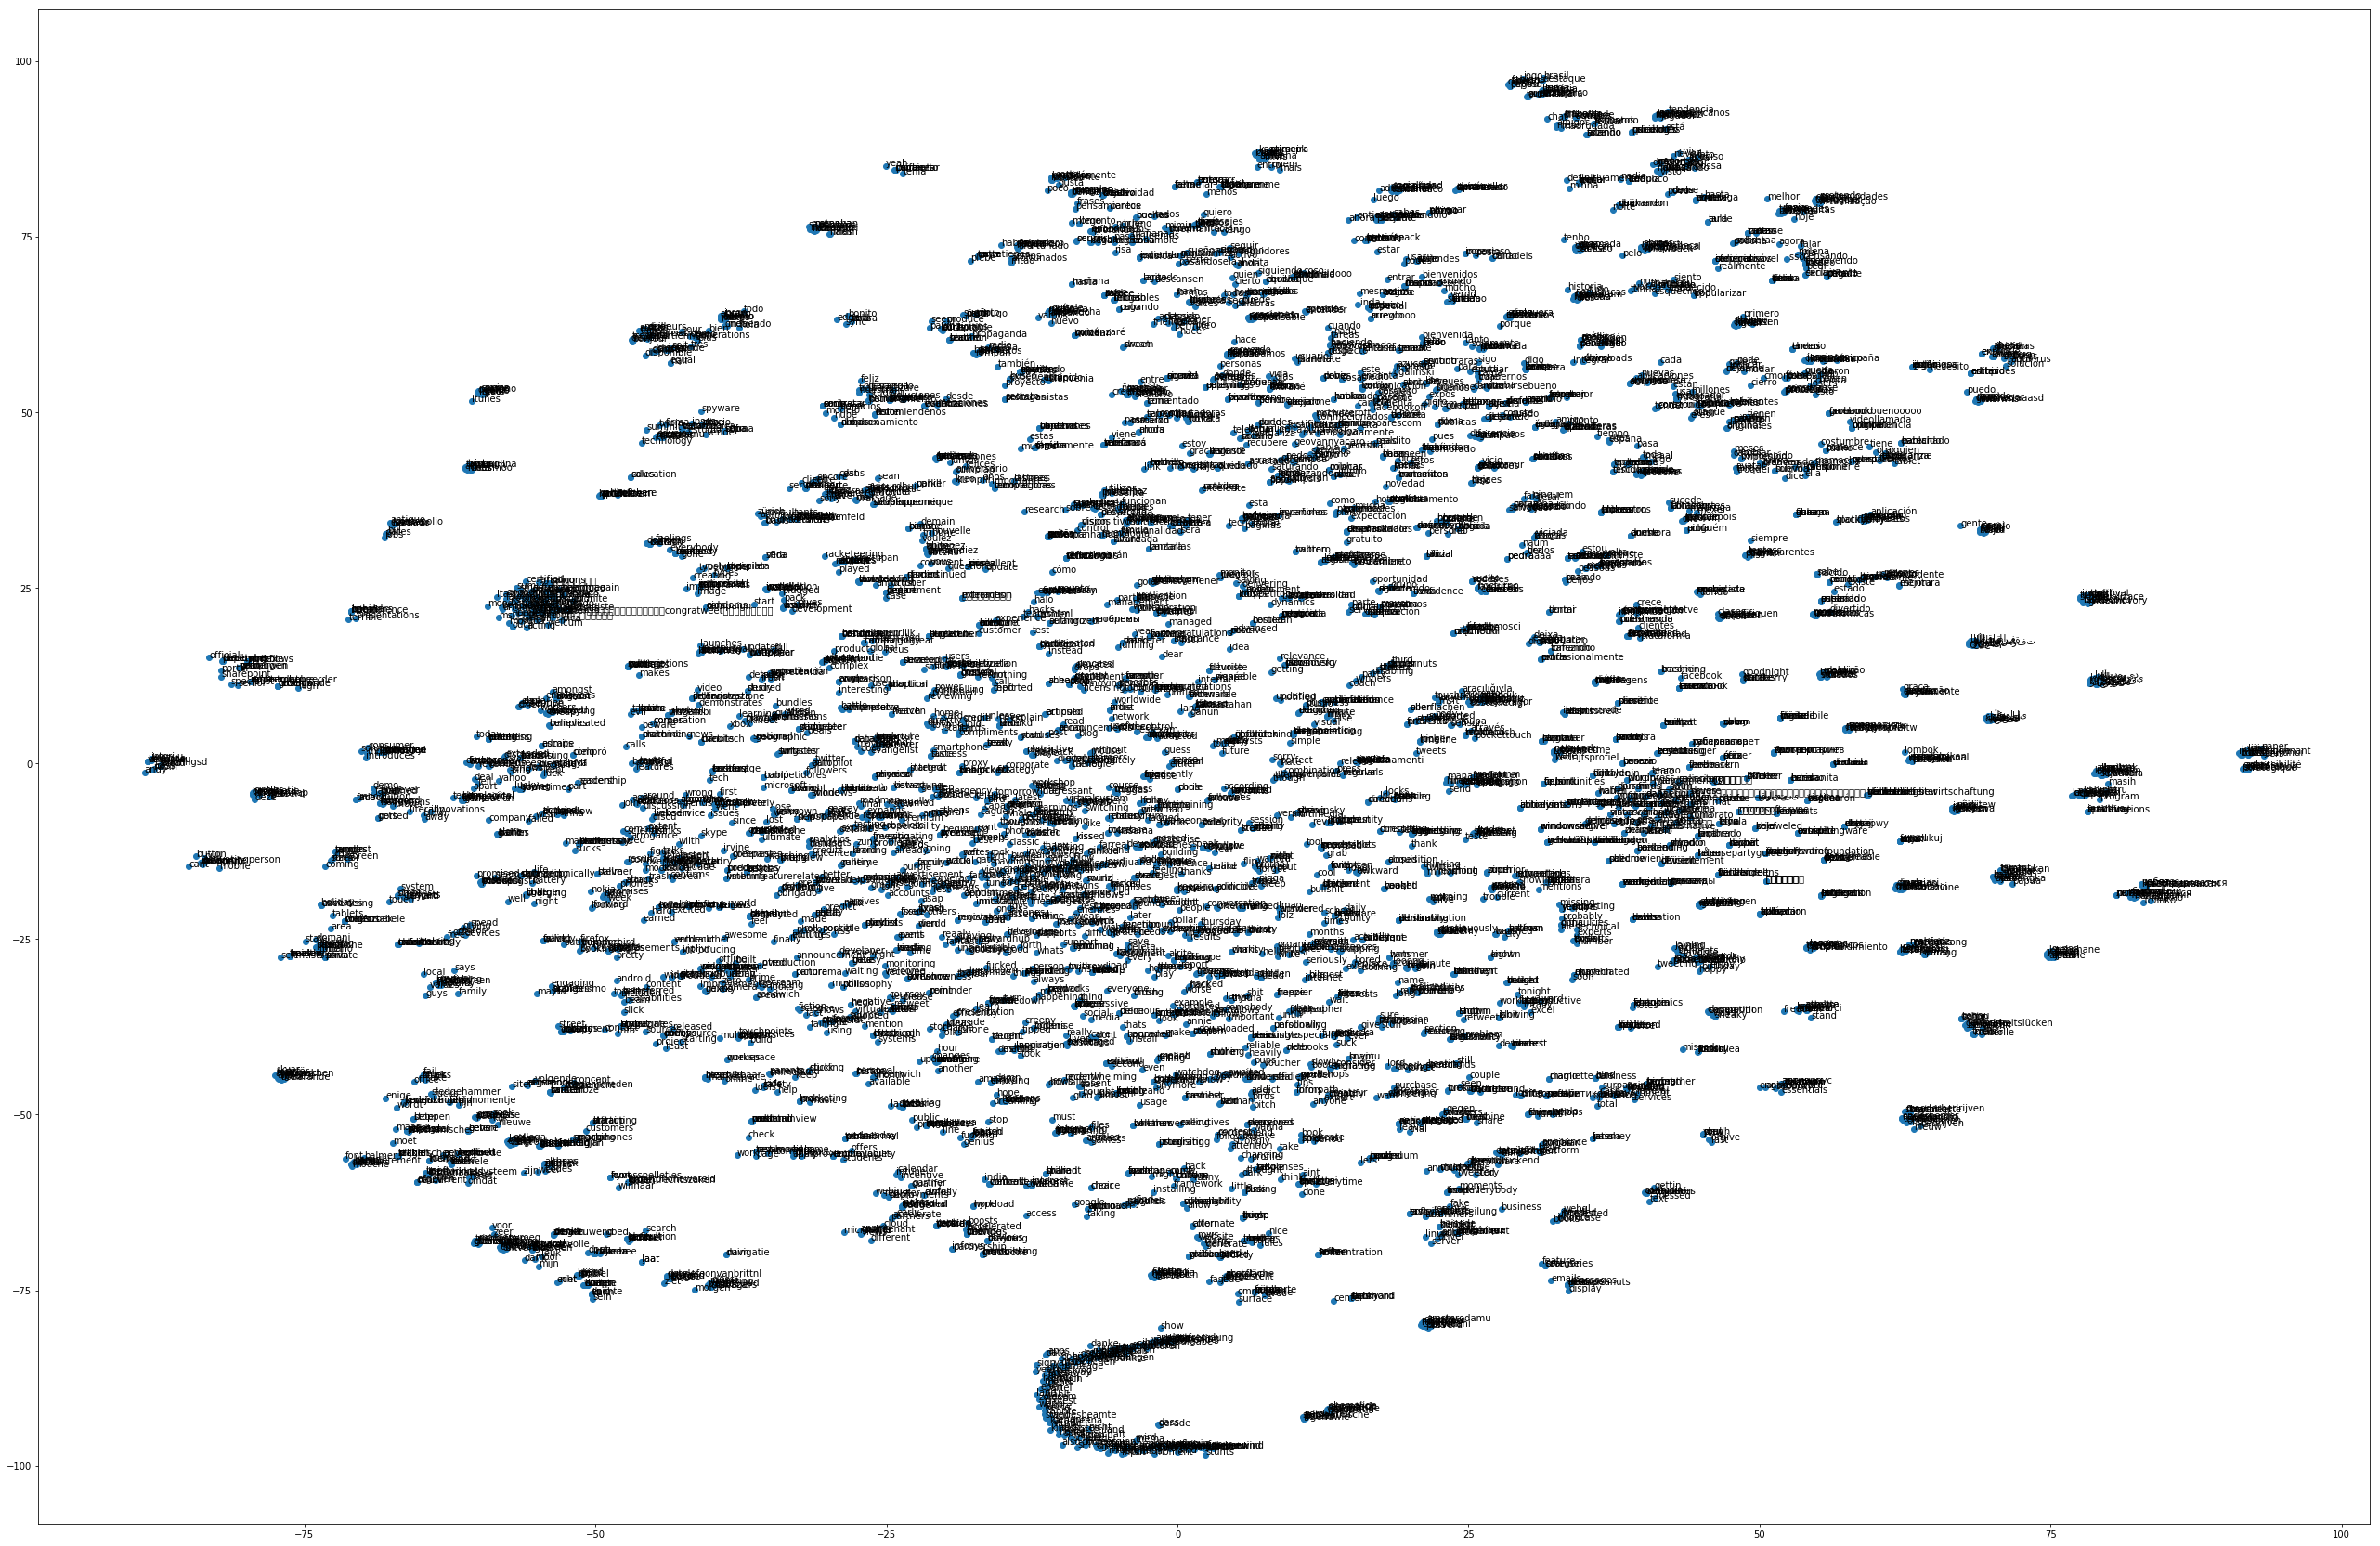

In [93]:
fig, ax = plt.subplots(figsize=(45, 30))

x2 = words_tsne[:,0]
y2 = words_tsne[:,1]

ax.scatter(x2, y2)

for i, txt in enumerate(vocab_list):
    ax.annotate(txt, (x2[i],y2[i]))

plt.show()

As we can see, the words are going in a certain group, but because of the huge amount of it is difficult to analyze. Since the classification is better cope computer

### Classifying Sentiments

### Training Vectors

Now let’s use these vectors to train a classifier. First, we must extract the training vectors. Remember that we have a total of 25000 training reviews, with equal numbers of positive and negative ones (12500 positive, 12500 negative).

Hence, we create a numpy array (since the classifier we use only takes numpy arrays. There are two parallel arrays, one containing the vectors (train_arrays) and the other containing the labels (train_labels).

We simply put the positive ones at the first half of the array, and the negative ones at the second half.  

In [94]:
train_arrays = numpy.zeros((327, 100))
train_labels = numpy.zeros(327)

for i in range(159):
    prefix_train_pos = 'TRAIN_POS_' + str(i)
    train_arrays[i] = model.docvecs[prefix_train_pos]
    train_labels[i] = 1
    
for i in range(168):
    prefix_train_neg = 'TRAIN_NEG_' + str(i)
    train_arrays[159 + i] = model.docvecs[prefix_train_neg]
    train_labels[159 + i] = 0

The training array looks like this: rows and rows of vectors representing each sentence.

In [95]:
print (train_arrays)

[[-0.14443821 -0.83260983 -0.84236681 ... -0.71553338  0.07499354
  -0.00435535]
 [ 0.12992804 -0.99795324 -1.15484405 ... -0.15886755  0.71238989
  -0.21467751]
 [-0.07509613 -0.85903478 -0.57222939 ... -0.15063146  0.10922384
  -0.16992405]
 ...
 [-0.54364717 -0.57441014 -1.16563606 ... -0.92855638  0.86783123
   0.16638038]
 [-0.51439226 -1.19828069 -0.6801489  ... -0.52087492  0.15656894
  -0.08764945]
 [ 0.19418597 -0.40109354 -0.17816982 ... -0.30374599 -0.07013044
   0.11613043]]


The labels are simply category labels for the sentence vectors – 1 representing positive and 0 for negative.

In [96]:
print (train_labels)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Testing Vectors

We do the same for testing data – data that we are going to feed to the classifier after we’ve trained it using the training data. This allows us to evaluate our results. The process is pretty much the same as extracting the results for the training data. 

In [97]:
test_arrays = numpy.zeros((114, 100))
test_labels = numpy.zeros(114)

for i in range(55):
    prefix_test_pos = 'TEST_POS_' + str(i)
    test_arrays[i] = model.docvecs[prefix_test_pos]
    test_labels[i] = 1
    
for i in range(59):
    prefix_test_neg = 'TEST_NEG_' + str(i)
    test_arrays[55 + i] = model.docvecs[prefix_test_neg]
    test_labels[55 + i] = 0

### Classification

Now we train a logistic regression classifier using the training data.

 

In [98]:
classifier = LogisticRegression(n_jobs=2)
classifier.fit(train_arrays, train_labels)

test_predict =  classifier.predict(test_arrays)
test_predict

/home/dmitriy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dmitriy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


array([0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.])

And find that we have achieved near 60% accuracy for sentiment analysis. This is rather incredible, given that we are only using a linear SVM and a very shallow neural network.

In [99]:
classifier.score(test_arrays, test_labels)

0.6403508771929824

Visualize results of our model. For this as before, we need to reduce the data dimension.

In [100]:
n_components = 2    # 2 for 2D
test_model_tsne = TSNE(n_components, random_state=0)
test_arrays_tsne = test_model_tsne.fit_transform(test_arrays)

Set the color for different classes.

In [101]:
class_color = ['green','red']

colors = [class_color[int(i)] for i in test_labels]

colors_predict = [class_color[int(i)] for i in test_predict]

Now we can see the result. For a better analysis of the point source and the predicted data to make different sizes. This allows you to see where the model was wrong.

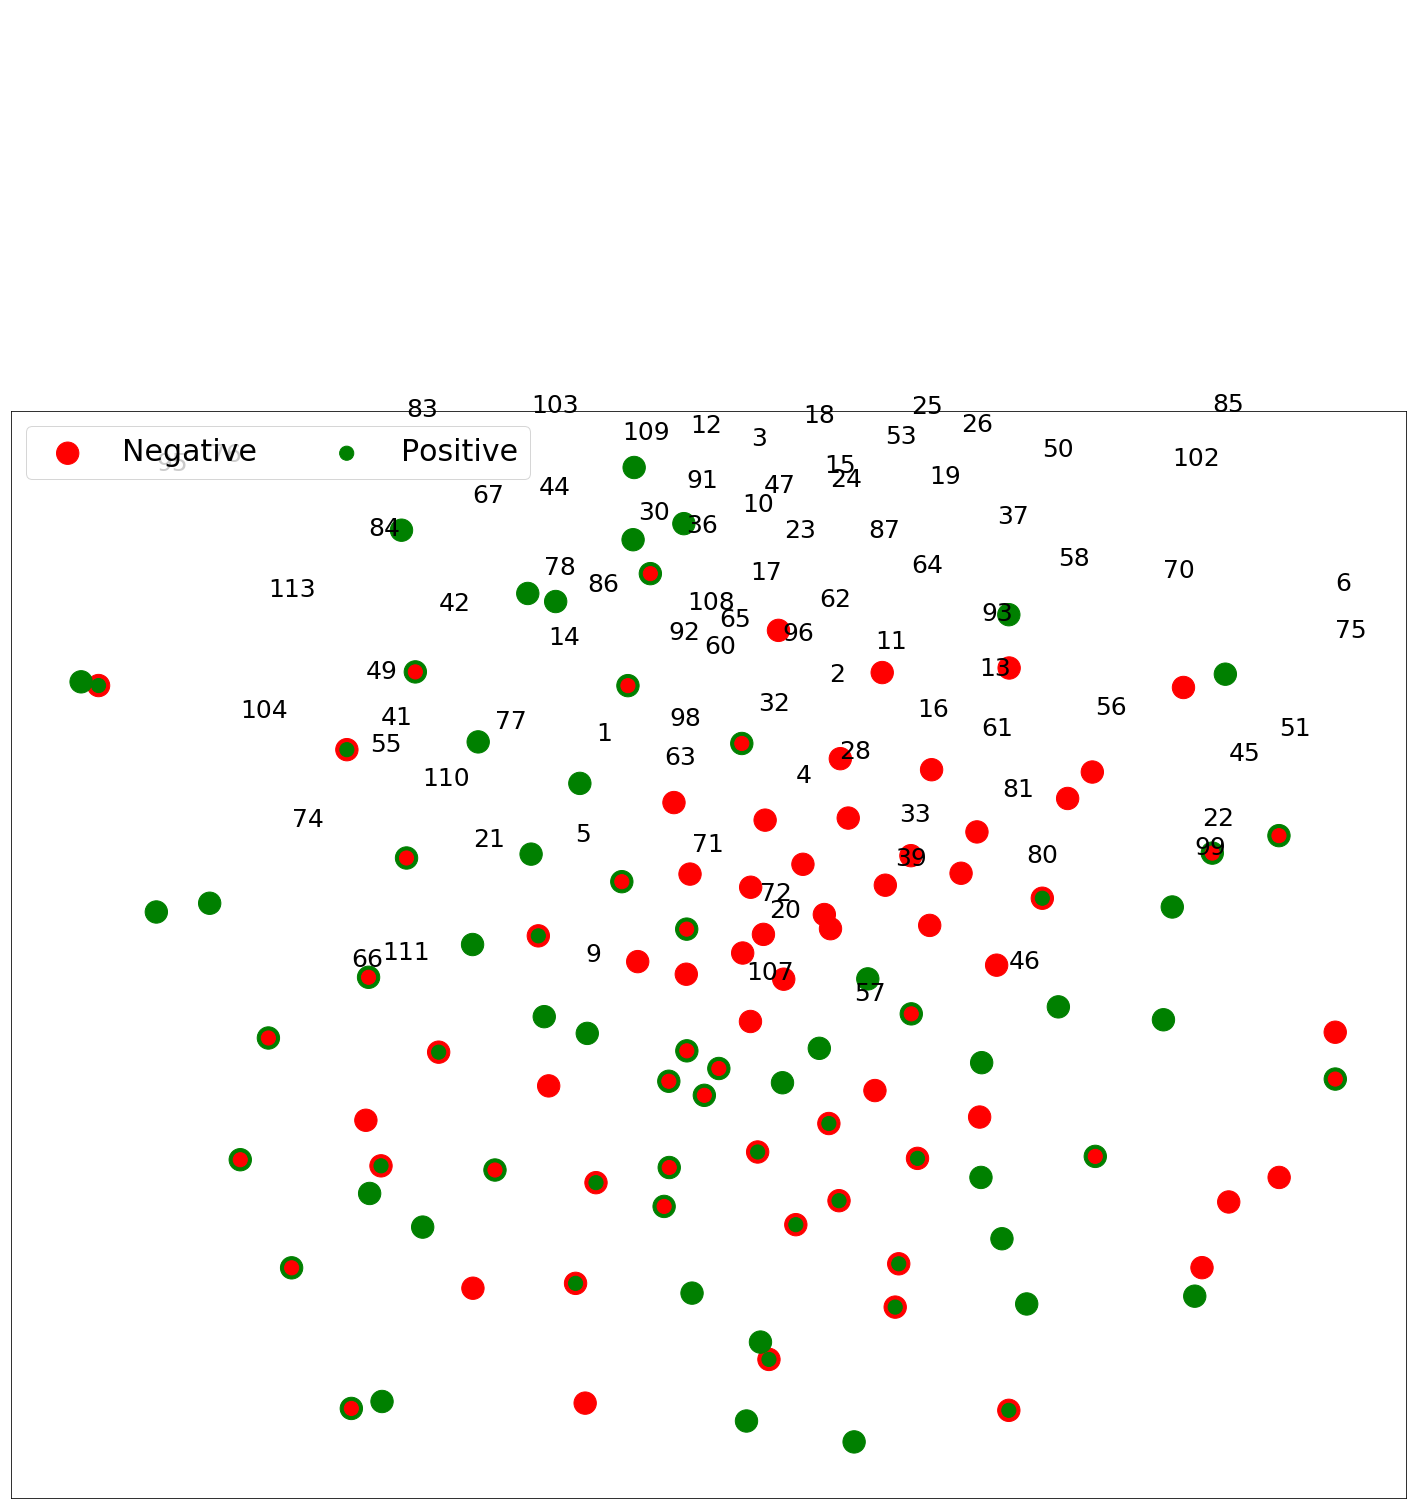

In [102]:
fig, ax = plt.subplots(figsize=(25, 20))

x = test_arrays_tsne[:,0]
y = test_arrays_tsne[:,1]
# Plot outputs
t = ax.scatter(x, y,  color=colors,alpha=1,s=500)
p = ax.scatter(x, y,  color=colors_predict,alpha=1,s=200)

for i in range(len(x)):
    ax.annotate(str(i), (x[i],y[i]+10),
             fontsize=25)

plt.xticks(())
plt.yticks(())

plt.legend((t, p),
           ('Negative','Positive'),
           scatterpoints=1,
           loc='upper left',
           ncol=2,fontsize=30)

plt.show()

Tweet length is too large to be displayed on the schedule, so the points are marked by indexes tweets. The resulting model can have a sufficiently high probability to assess the mood of tweets, but for best results you need more data for training.

## Exercise 2
We have three files with tweets `./exercise/tweets/neg.txt,./exercise/tweets/pos.txt,./exercise/tweets/unsup.txt`. Build Doc2Vec model with such parameters `min_count=1`, `window=15`, `size=100`, `sample=1e-4`, `negative=5`, `seed=42` (read [here](https://radimrehurek.com/gensim/models/doc2vec.html) about their destination) and get 10 most similar words to the word `"google"`. Write these words to the `result` list. Train the model 10 times, i.e. use 10 epochs.

In [103]:
sources = {'./exercise/tweets/neg.txt':'TRAIN_NEG', './exercise/tweets/pos.txt':'TRAIN_POS', './exercise/tweets/unsup.txt':'TRAIN_UNS'}


In [107]:

sources = {'./tweets/neg.txt':'TRAIN_NEG', './tweets/pos.txt':'TRAIN_POS', './tweets/unsup.txt':'TRAIN_UNS'}

sentences = LabeledLineSentence(sources)

model = Doc2Vec(min_count=1, window=15, vector_size=100, sample=1e-4, negative=5, seed=42)

model.build_vocab(sentences.to_array())

result = model.wv.most_similar('google', topn=10)
print(result)

[('nueva', 0.3592076897621155), ('newt', 0.3471664488315582), ('tienen', 0.33843696117401123), ('fringe', 0.3373158574104309), ('apache', 0.32414865493774414), ('avez', 0.32057106494903564), ('student', 0.3175703287124634), ('intégration', 0.31556230783462524), ('electricsoup', 0.30255618691444397), ('totally', 0.30225875973701477)]


In [ ]:
Test.checkDoc2Vec(model, result, 2)

## 3. LDA
Latent Dirichlet allocation (LDA) is a topic model that generates topics based on word frequency from a set of documents. LDA is particularly useful for finding reasonably accurate mixtures of topics within a given document set.

###  Importing your documents
Here is our sample documents:

In [109]:
# doc_set = open('./new_tweets/alltweets.txt').read().decode("utf-8", "ignore").split('\n')
doc_set = open('./new_tweets/alltweets.txt').read().split('\n')
len(doc_set)

1963

### Cleaning your documents
Data cleaning is absolutely crucial for generating a useful topic model. :

#### Tokenization
In this case, we are interested in tokenizing to words. We are using NLTK’s tokenize.regexp module:

In [110]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

The above code will match any word characters until it reaches a non-word character, like a space.

In [111]:
doc_tokens = []
for doc in doc_set:
    doc_tokens.append(tokenizer.tokenize(doc.lower()))

print(doc_tokens[0])

['siri', 'is', 'amazing']


Our document from doc_a is now a list of tokens.

#### Stop words
In our case, we are using the stop_words package from Pypi, a relatively conservative list. We can call get_stop_words() to create a list of stop words.

In [112]:
from stop_words import get_stop_words

en_stop = get_stop_words('en')

Removing stop words is now a matter of looping through our tokens and comparing each word to the en_stop list.

In [113]:
doc_stopped_tokens = []
for tokens in doc_tokens:
    doc_stopped_tokens.append([i for i in tokens if not i in en_stop and len(i)>3])

print(doc_stopped_tokens[0])

['siri', 'amazing']


#### Stemming
The Porter stemming algorithm is the most widely used method. To implement a Porter stemming algorithm, import the Porter Stemmer module from NLTK: 

In [114]:
from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

Note that p_stemmer requires all tokens to be type str. p_stemmer returns the string parameter in stemmed form, so we need to loop through our stopped_tokens:

In [115]:
texts = []
for tokens in doc_stopped_tokens:
    texts.append([p_stemmer.stem(i) for i in tokens])

print(texts[0])

['siri', 'amaz']


In our example, not much happened: likes became like.

#### Constructing a document-term matrix
The result of our cleaning stage is texts, a tokenized, stopped and stemmed list of words from a single document. Let’s fast forward and imagine that we looped through all our documents and appended each one to texts. So now texts is a list of lists, one list for each of our original documents.

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim: 

In [116]:
from gensim import corpora, models

dictionary = corpora.Dictionary(texts)

The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of documents. In each document vector is a series of tuples. As an example, print(corpus[0]) results in the following:

In [117]:
corpus = [dictionary.doc2bow(text) for text in texts]

The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of documents. In each document vector is a series of tuples. As an example, print(corpus[0]) results in the following:

In [118]:
print(corpus[0])

[(0, 1), (1, 1)]


This list of tuples represents our first document, doc_a. The tuples are (term ID, term frequency) pairs, so if print(dictionary.token2id) says brocolli’s id is 0, then the first tuple indicates that brocolli appeared twice in doc_a. doc2bow() only includes terms that actually occur: terms that do not occur in a document will not appear in that document’s vector.

### Applying the LDA model
corpus is a document-term matrix and now we’re ready to generate an LDA model: 

In [119]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

The LdaModel class is described in detail in the gensim documentation. Parameters used in our example:

Parameters:

- num_topics: required. An LDA model requires the user to determine how many topics should be generated. Our document set is small, so we’re only asking for three topics.
- id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
- passes: optional. The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.


#### Examining the results
Our LDA model is now stored as ldamodel. We can review our topics with the print_topic and print_topics methods:

In [120]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.033*"sandwich" + 0.032*"cream" + 0.023*"android"'), (1, '0.018*"iphon" + 0.011*"just" + 0.011*"like"'), (2, '0.026*"nexu" + 0.023*"galaxi" + 0.012*"samsung"')]


What does this mean? Each generated topic is separated by a comma. Within each topic are the three most probable words to appear in that topic. Even though our document set is small the model is reasonable. 
Adjusting the model’s number of topics and passes is important to getting a good result. Two topics seems like a better fit for our documents:

In [121]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)

In [122]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(0, '0.011*"iphon" + 0.011*"store" + 0.008*"just" + 0.007*"thank"'), (1, '0.022*"cream" + 0.022*"sandwich" + 0.021*"nexu" + 0.020*"googl"')]


In [126]:
ldamodel.top_topics(corpus)

[([(0.010668357, 'iphon'),
   (0.010550855, 'store'),
   (0.008248082, 'just'),
   (0.0067948797, 'thank'),
   (0.0067852153, 'like'),
   (0.005872579, 'siri'),
   (0.0057041147, 'updat'),
   (0.0055432776, 'love'),
   (0.0054950826, 'search'),
   (0.0052743526, 'great'),
   (0.0052011, 'want'),
   (0.0050133597, 'phone'),
   (0.0048446013, 'time'),
   (0.0046952455, 'make'),
   (0.0045055924, 'microsoft'),
   (0.0041354825, 'will'),
   (0.0040935213, 'servic'),
   (0.0040291552, 'upgrad'),
   (0.003918397, 'steve'),
   (0.003858586, 'work')],
  -8.44063158961803),
 ([(0.021757867, 'cream'),
   (0.021631282, 'sandwich'),
   (0.020846644, 'nexu'),
   (0.0197809, 'googl'),
   (0.018387474, 'galaxi'),
   (0.017524205, 'android'),
   (0.009287522, 'samsung'),
   (0.008599932, 'iphon'),
   (0.008305834, 'phone'),
   (0.005211484, 'releas'),
   (0.0045477576, 'appl'),
   (0.0038320606, 'featur'),
   (0.0035560555, 'million'),
   (0.003439834, 'announc'),
   (0.0034254838, 'launch'),
   (0.00

For a more convenient and quick analysis, there is a ready solution that allows you to interactively explore lda model.

<a href="https://pyldavis.readthedocs.io/en/latest/">pyLDAvis</a> is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The visualization is intended to be used within an IPython notebook but can also be saved to a stand-alone HTML file for easy sharing.

To install:

`pip install pyldavis`

Create model with 10 topics

In [127]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

Import pyLDAvis and enable interactive work in Ipython notebook

In [128]:
import pyLDAvis
pyLDAvis.enable_notebook()

Visualize our model

In [133]:
# pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
from pyLDAvis import gensim as gensim1
gensim1.prepare(ldamodel, corpus, dictionary)
# pyLDAvis.show()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.081792 -0.178927       1        1  13.500120
4      0.076330 -0.072248       2        1  13.455846
0      0.073611 -0.027682       3        1  12.337928
9     -0.236396  0.053843       4        1  10.871994
6      0.023131  0.115802       5        1   9.384854
5      0.015627  0.021901       6        1   9.144341
3      0.077828  0.036896       7        1   8.348296
2      0.006081  0.035391       8        1   7.818385
1      0.032743 -0.032882       9        1   7.685195
8      0.012837  0.047905      10        1   7.453047, topic_info=     Category        Freq                 Term       Total  loglift  logprob
term                                                                        
163   Default  127.000000             sandwich  127.000000  30.0000  30.0000
161   Default  128.000000                cream  128.000000  29.0000  29.0000
19    Default  128.000000                 nexu  128.000000  28.0000  28.0000
18    Default  113.000000               galaxi  113.000000  27.0000  27.0000
160   Default  108.000000              android  108.000000  26.0000  26.0000
57    Default  125.000000                googl  125.000000  25.0000  25.0000
10    Default  126.000000                iphon  126.000000  24.0000  24.0000
141   Default   57.000000              samsung   57.000000  23.0000  23.0000
68    Default   37.000000               search   37.000000  22.0000  22.0000
108   Default   77.000000                store   77.000000  21.0000  21.0000
110   Default   24.000000                pleas   24.000000  20.0000  20.0000
438   Default   39.000000                 love   39.000000  19.0000  19.0000
276   Default   39.000000                 want   39.000000  18.0000  18.0000
235   Default   39.000000                great   39.000000  17.0000  17.0000
497   Default   16.000000              ballmer   16.000000  16.0000  16.0000
82    Default   38.000000                steve   38.000000  15.0000  15.0000
649   Default   19.000000               unveil   19.000000  14.0000  14.0000
21    Default   31.000000               releas   31.000000  13.0000  13.0000
523   Default   17.000000                 hand   17.000000  12.0000  12.0000
1     Default   48.000000                 siri   48.000000  11.0000  11.0000
28    Default   22.000000              million   22.000000  10.0000  10.0000
15    Default   84.000000                phone   84.000000   9.0000   9.0000
75    Default   26.000000                 wait   26.000000   8.0000   8.0000
31    Default   15.000000              weekend   15.000000   7.0000   7.0000
247   Default   25.000000               window   25.000000   6.0000   6.0000
80    Default   24.000000                  job   24.000000   5.0000   5.0000
242   Default   28.000000                avail   28.000000   4.0000   4.0000
994   Default   15.000000                digit   15.000000   3.0000   3.0000
239   Default   30.000000                 ipad   30.000000   2.0000   2.0000
322   Default   17.000000                touch   17.000000   1.0000   1.0000
...       ...         ...                  ...         ...      ...      ...
281   Topic10    3.020710               holdem    4.477703   2.2029  -5.7453
1577  Topic10    4.496850                webgl    6.679307   2.2009  -5.3475
1971  Topic10    3.009826                globe    4.515870   2.1908  -5.7490
523   Topic10   11.298429                 hand   17.371925   2.1664  -4.4262
12    Topic10    9.118022                 turn   15.674051   2.0548  -4.6406
1387  Topic10    3.656287                 mayb    5.996294   2.1019  -5.5544
524   Topic10    5.970932             research   10.546992   2.0276  -5.0639
1256  Topic10    1.963348                  pay    2.986820   2.1770  -6.1762
92    Topic10    3.760108                poker    6.731848   2.0141  -5.5264
1328  Topic10    3.021766                three    5.241271   2.0458  -5.745

### So what does LDA actually do?
This explanation is a little lengthy, but useful for understanding the model we worked so hard to generate.

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution, like the ones in our walkthrough model. In other words, LDA assumes a document is made from the following steps:

- Determine the number of words in a document. Let’s say our document has 6 words.
- Determine the mixture of topics in that document. For example, the document might contain 1/2 the topic “health” and 1/2 the topic “vegetables.”
- Using each topic’s multinomial distribution, output words to fill the document’s word slots. In our example, the “health” topic is 1/2 our document, or 3 words. The “health” topic might have the word “diet” at 20% probability or “exercise” at 15%, so it will fill the document word slots based on those probabilities.
Given this assumption of how documents are created, LDA backtracks and tries to figure out what topics would create those documents in the first place.

## Exercise 3
Read "Hamlet" and "Romeo and Juliet" by W. Shakespeare from provided files (`hamlet.txt`, `Romeo and Juliet.txt` inside `ws` folder). Then you need to process files content like it was done before:
* convert text to lowercase
* split into separated words
* remove English stopwords and too short words (less then 3 characters in a word)
* reduce inflected words to their word stem, base or root form using again `PorterStemmer`.
Then use these processed strings for finding of two most popular topics with the help of LDA model with `passes=20`. For each topic extract three words with the largest weights and write results to the `result` variable in the form:
```
[
["the_most_important_word_of_topic_1",
   "word_with_the_second_largest_weight_of_topic_1",
   "word_with_the_third_largest_weight_of_topic_1"],
   ["the_most_important_word_of_topic_2",
   "word_with_the_second_largest_weight_of_topic_2",
   "word_with_the_third_largest_weight_of_topic_2"]
]
```

In [ ]:
doc_set = [
        open('./ws/hamlet.txt').read(),
        open('./ws/Romeo and Juliet.txt').read()
    ]

In [154]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

doc_tokens = []
for doc in doc_set:
    doc_tokens.append(tokenizer.tokenize(doc.lower()))

print(doc_tokens[0])

from stop_words import get_stop_words

en_stop = get_stop_words('en')

doc_stopped_tokens = []
for tokens in doc_tokens:
    doc_stopped_tokens.append([i for i in tokens if not i in en_stop and len(i)>3])

print(doc_stopped_tokens[0])

from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

texts = []
for tokens in doc_stopped_tokens:
    texts.append([p_stemmer.stem(i) for i in tokens])

print(texts[0])

from gensim import corpora, models

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

print(corpus[0])

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)

list1 = ldamodel.print_topics(num_topics=2, num_words=3)
print(list1)

['siri', 'is', 'amazing']
['siri', 'amazing']
['siri', 'amaz']
[(0, 1), (1, 1)]
[(0, '0.019*"iphon" + 0.008*"siri" + 0.006*"updat"'), (1, '0.019*"cream" + 0.019*"sandwich" + 0.019*"googl"')]


In [156]:
list2 = [i[-1].split(' + ') for i in list1]
print(list2)
list3 = [k.split('"')[1] for i in list2 for k in i]
list3 = []
for i in list2:
    list4 = []
    for k in i:
        list4.append(k.split('"')[1])
    list3.append(list4)
    list4 = []
result = list3

print(result)

[['0.019*"iphon"', '0.008*"siri"', '0.006*"updat"'], ['0.019*"cream"', '0.019*"sandwich"', '0.019*"googl"']]
[['iphon', 'siri', 'updat'], ['cream', 'sandwich', 'googl']]


In [ ]:
Test.checkLDAModel(ldamodel, corpus, result, 3)

<center><h3>Presented by <a target="_blank" rel="noopener noreferrer nofollow" href="http://datascience-school.com">datascience-school.com</a></h3></center>